In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import IPython
import tensorflow_datasets as tfds
from pytz import timezone
from datetime import datetime
from config import cfg
from model_mnist import *
from utils import *
from loss import *
from Inception_score import *

Using TensorFlow backend.


## MNIST

### show 

In [2]:
(train_mnist,_),(_,_) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

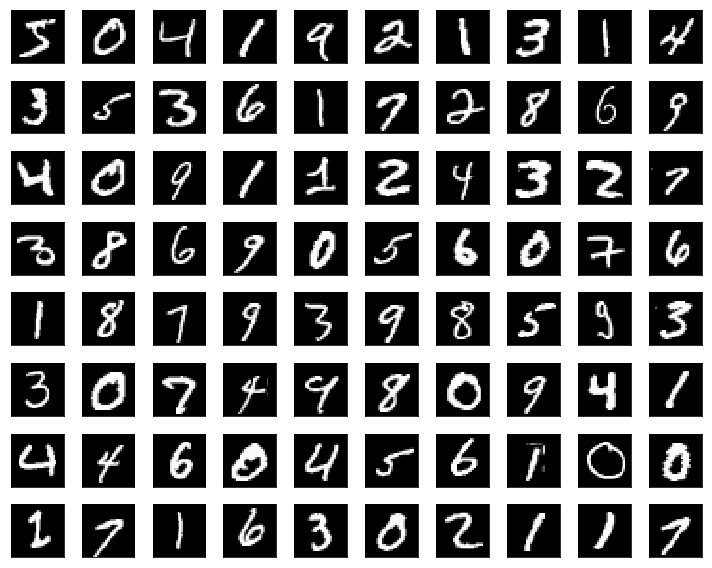

In [3]:
plt.figure(figsize=(10, 8))
for i in range(80):
    plt.subplot(8, 10, i+1)
    plt.imshow(train_mnist[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [4]:
# instantiate generator and discriminator 
generator = make_generator_model_mnist()
discriminator = make_discriminator_model_mnist()

In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
re_lu (ReLU)                 (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 128)         0

In [6]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 256)        

### preprocess data

In [7]:
# preprocess data
train_data = get_train_data('mnist')

### generate 

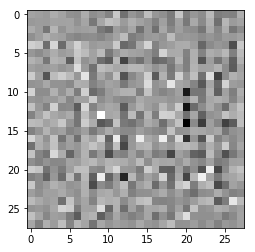

In [8]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0],cmap = 'gray')

### instantiate optimizer

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.5, beta_2 = 0.99999, decay = 1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate =1e-4, beta_1 = 0.5, beta_2 = 0.99999, decay = 1e-5)

### set hyperparameters

In [10]:
EPOCHS = cfg.EPOCHS
noise_dim = cfg.NOISE_DIM
num_examples_to_generate = cfg.NUM_EXAMPLES_TO_GENERATE
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### set direction

In [11]:
now = datetime.now(timezone('US/Eastern'))

subfile = now.strftime("%m_%d_%H_%M")

filedir = os.path.join(cfg.IMAGE_PATH,subfile)

checkpoint_dir = filedir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

if (not os.path.exists(cfg.IMAGE_PATH)):
    os.mkdir(cfg.IMAGE_PATH)

if (not os.path.isfile(filedir)):
    os.mkdir(filedir)

savedir = filedir
print(savedir)

./saveimage/12_13_20_40


### start training

In [12]:
@tf.function
def train_step(images, showloss = False):
    noise = tf.random.normal([cfg.BATCH_SIZE, cfg.NOISE_DIM])
    
    g_loss = generator_loss
    d_loss = discriminator_loss
        
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = g_loss(fake_output)
        disc_loss = d_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss    
    
def train(dataset, epochs, savedir):
    IS_mean = []
    IS_std = []
    G_loss = []
    D_loss = []
    for epoch in range(epochs):
        start = time.time()
        i = 0
        g_loss = 0
        d_loss = 0
        for image_batch in dataset:
            i += 1
            if (i+1) % cfg.SHOW_LOSS ==0:
                g_tensor, d_tensor = train_step(image_batch, showloss = True)
            else:
                g_tensor, d_tensor = train_step(image_batch)
            g_loss += float(g_tensor.numpy())
            d_loss += float(d_tensor.numpy())
        
        G_loss.append(g_loss / i)
        D_loss.append(d_loss / i)
        # Produce images for the GIF
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,savedir)
        
        # Save the model every 15 epochs
        if (epoch + 1) % 5 == 0:
            mean, std = IS(generator, 1000, 100)
            IS_mean.append(mean)
            IS_std.append(std)
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # clear outputs
    display.clear_output(wait=True)
    
    # save IS score and Loss plot
    IS_mean = np.array(IS_mean)
    IS_std = np.array(IS_std)
    IS_df = pd.DataFrame({'mean':IS_mean, 'mean+std':IS_mean+IS_std, 'mean-std':IS_mean-IS_std, 'std':IS_std})
    IS_df.index = [5 * (x + 1) for x in range(IS_df.shape[0])]
    Loss_df = pd.DataFrame({'Generater':G_loss, 'Discriminator':D_loss})
    
    df_path = os.path.join(savedir, 'IS_score.csv')
    IS_df.to_csv(path_or_buf=df_path, index=False)
    df_path2 = os.path.join(savedir, 'Loss.csv')
    Loss_df.to_csv(path_or_buf=df_path2, index=False)
    print('Inception score and loss save complete')
    
    path = os.path.join(savedir, 'IS_score_trend.png')
    fig = plt.figure(figsize=(6, 6))
    plt.plot(IS_df[['mean','mean+std','mean-std']])
    plt.title('Inception Scores')
    plt.legend(IS_df[['mean','mean+std','mean-std']].columns, loc='best')
    plt.savefig(path)
    #plt.close('all')
    
    path2 = os.path.join(savedir, 'Loss_trend.png')
    fig2 = plt.figure(figsize=(6, 6))
    plt.plot(Loss_df)
    plt.title('Validation Losses')
    plt.legend(Loss_df.columns, loc='best')
    plt.savefig(path2)
    
    # Generate after the final epoch
    generate_and_save_images(generator,
                           epochs,
                           seed,savedir)

In [13]:
train(train_data, EPOCHS,savedir)

Inception score and loss save complete


### Visualization the results

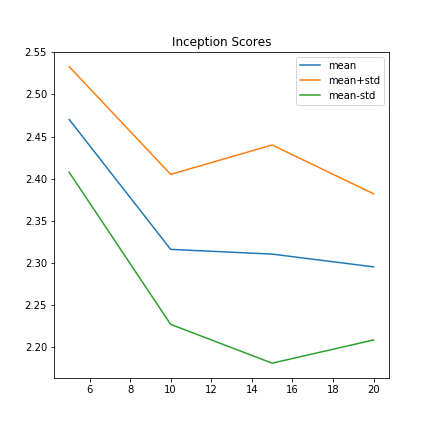

In [14]:
from IPython.display import Image
Image(filename= (savedir+'/IS_score_trend.png'))

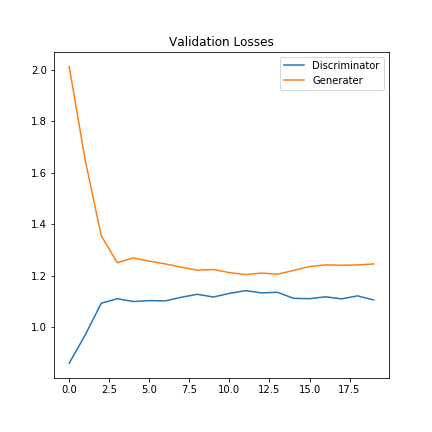

In [15]:
Image(filename = (savedir+'/Loss_trend.png'))

In [19]:
if cfg.GIF:
    anim_file = subfile+'gan.gif'
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(filedir+'/image*.png')
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

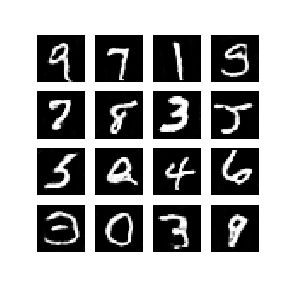

In [22]:
display.Image(savedir+'/image_at_epoch_{:04d}.png'.format(cfg.EPOCHS))

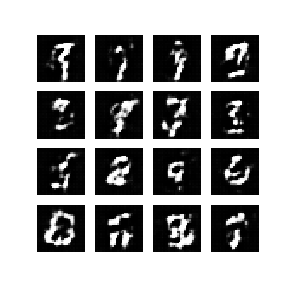

In [20]:
display.Image(filename=anim_file)

## SVHN

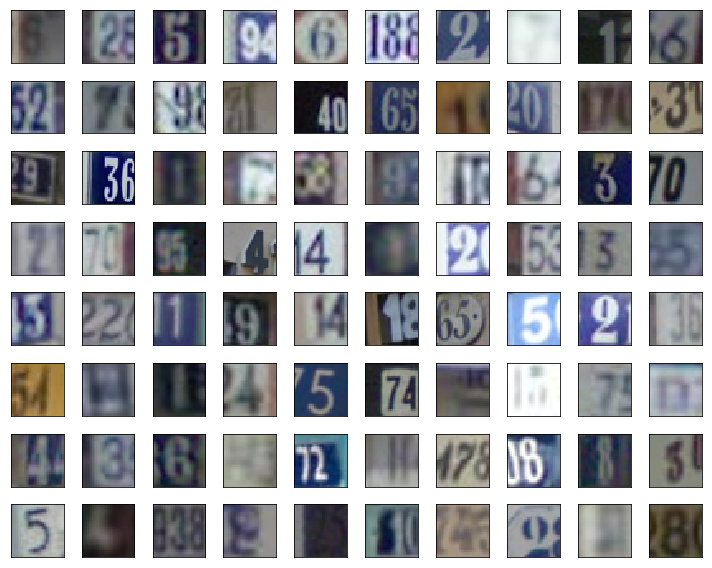

In [31]:
# clear storage
del train_data
del train_mnist
# show image
(train_data,_) = tfds.load(name="svhn_cropped", split=["train","test"], shuffle_files=True )
train_iter = iter(train_data)
plt.figure(figsize=(10, 8))
for i in range(80):
    plt.subplot(8, 10, i+1)
    plt.imshow(next(train_iter)['image'])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [46]:
del train_data
del train_iter
cfg.IMG_SIZE = 32
train_data = get_train_data('svhn')

In [39]:
from model_svhn import make_generator_model_svhn, make_discriminator_model_svhn
generator = make_generator_model_svhn()
discriminator = make_discriminator_model_svhn()

In [40]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_12 (Batc (None, 4096)              16384     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 8, 8, 128)        

In [41]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 128)       6144      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
average_pooling2d_6 (Average (None, 16, 16, 128)       0         
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       524288    
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 16, 256)      

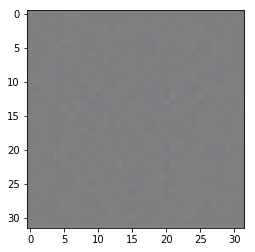

In [57]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow((generated_image[0, :, :, :]* 127.5 + 127.5)/255)

In [43]:
now = datetime.now(timezone('US/Eastern'))

subfile = now.strftime("%m_%d_%H_%M")

filedir = os.path.join(cfg.IMAGE_PATH,subfile)

checkpoint_dir = filedir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

if (not os.path.exists(cfg.IMAGE_PATH)):
    os.mkdir(cfg.IMAGE_PATH)

if (not os.path.isfile(filedir)):
    os.mkdir(filedir)

savedir = filedir
print(savedir)

./saveimage/12_13_21_07


In [50]:
train(train_data, EPOCHS,savedir)

ValueError: in converted code:

    <ipython-input-12-5ebf98e1d2c8>:11 train_step  *
        real_output = discriminator(images, training=True)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/sequential.py:256 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/network.py:708 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/network.py:860 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/base_layer.py:812 __call__
        self.name)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/input_spec.py:213 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense_5 is incompatible with the layer: expected axis -1 of input shape to have value 8192 but received input with shape [64, 4608]


In [ ]:
Image(filename= (savedir+'/IS_score_trend.png'))

In [63]:
for epoch in range(1):
    for image_batch in train_data:
        i += 1
        if (i+1) % cfg.SHOW_LOSS ==0:
            g_tensor, d_tensor = train_step(image_batch)
        else:
            g_tensor, d_tensor = train_step(image_batch)
        g_loss += float(g_tensor.numpy())
        d_loss += float(d_tensor.numpy())
        break
    break

    G_loss.append(g_loss / i)
    D_loss.append(d_loss / i)

ValueError: in converted code:

    <ipython-input-12-5ebf98e1d2c8>:11 train_step  *
        real_output = discriminator(images, training=True)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/sequential.py:256 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/network.py:708 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/network.py:860 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/base_layer.py:812 __call__
        self.name)
    /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/engine/input_spec.py:213 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense_5 is incompatible with the layer: expected axis -1 of input shape to have value 8192 but received input with shape [64, 4608]
